# DAML 04 - Pandas Introduction

Michal Grochmal <michal.grochmal@city.ac.uk>

Wrapper on top of `NumPy` (and `Matplotlib` to some extent) to make up for the shortcomings
of those two libraries when working with of real-world data.
Instead of working towards efficient
numerical computing it attempts to make working with messy data less annoying.

Let's import it,
and also let's import `NumPy` to see how both libraries work with each other.
`pandas.options` holds several variables which are used when displaying the data.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 12

## General ideas behind pandas

Originally built as an enhanced version of R's `data.frame`,
`pandas` incorporates several known APIs into a single structure.
The `DataFrame` includes APIs that make it easy for use from different perspectives.

* R `data.frame` like structure, extended by multi-indexes
* SQL-like joins, without need for external libraries (e.g. `sqldf` in R)
* Looks like a spreadsheet (yes, that is intentional)
* One can move between two and multidimensional representations (`stack`, `unstack`)
* Aggregation across dimensions with `groupby` (similar to SQL)

You will use `pandas` (rather than `NumPy`) for tasks around messy data.
`pandas` is built atop `NumPy`, and uses the continuous memory and broadcast operations
of `NumPy` arrays to boost its performance.  `pandas` excels at:

* Importing data (very resilient compared to `numpy.loadtxt`)
* Clean up messy data (`dropna` or `fillna`)
* Gain insight into data (`describe`)

Let's use some data about the British isles and the United Kingdom to demonstrate
some of the features:

In [2]:
country = ['Northern Ireland', 'Scotland', 'Wales', 'England', 'Isle of Man']
capital = ['Belfast', 'Edinburgh', 'Cardiff', 'London', 'Douglas']
area = np.array([14130, 77933, 20779, 130279, 572])
population2017 = np.array([1876695, 5404700, np.nan, 55268100, np.nan])
population2011 = np.array([1810863, 5313600, 3063456, 53012456, 83314])

# Series

The main feature of `pandas` is its `DataFrame` but that is a collection of `Series` data structures.
A `Series` is pretty similar to a `NumPy` array: it is a list of several data of the same data type.
The difference is that the `Series` adds labels (an index) to the data.

In [3]:
series_area = pd.Series(area)
series_area

0     14130
1     77933
2     20779
3    130279
4       572
dtype: int64

In [4]:
uk_area = pd.Series(area, index=country)
uk_area

Northern Ireland     14130
Scotland             77933
Wales                20779
England             130279
Isle of Man            572
dtype: int64

### Selection from the index

Selecting from a `Series` works both as a list or as a dictionary.
You can say that a `Series.index` maps keys over `Series.values`.

In [5]:
uk_area.values, uk_area.values.dtype, uk_area.index

(array([ 14130,  77933,  20779, 130279,    572]),
 dtype('int64'),
 Index(['Northern Ireland', 'Scotland', 'Wales', 'England', 'Isle of Man'], dtype='object'))

All the following three forms of indexing produce the same record.

In [6]:
uk_area['Wales'], uk_area[2], uk_area.values[2]

(20779, 20779, 20779)

Slicing works too, so does fancy indexing.

In [7]:
uk_area[0:3]

Northern Ireland    14130
Scotland            77933
Wales               20779
dtype: int64

In [8]:
uk_area[['Wales', 'Scotland']]

Wales       20779
Scotland    77933
dtype: int64

### Sorted and unsorted indexes

Slicing works on indexes (the labels of the data)
but it is only likely to produce meaningful results if the index is sorted.

Note: In older versions of `pandas` slicing over an unsorted index produced an error,
this still happens over a multi-index (outlined in a later section).
Since we did not care about the order when constructing the data frame our index is unsorted,
therefore slicing it will produce strange results.

In [9]:
uk_area['England':'Scotland']  # oops!

Series([], dtype: int64)

If we sort the index,
the alphabetical order (or actually ASCIIbetical order) of the labels can be used for slicing.

In [10]:
uk_area.sort_index(inplace=True)
uk_area['England':'Scotland']

England             130279
Isle of Man            572
Northern Ireland     14130
Scotland             77933
dtype: int64

### Implicit indexes

If you do not define an index you can still select and slice series items.
This is because apart from the normal index an implicit, positional, index is created.
In other words, every `pandas` series has two indexes: the implicit and the explicit index.

In [11]:
series_area = pd.Series(area)
series_area[0:3]

0    14130
1    77933
2    20779
dtype: int64

Moreover, when the explicit index is non-numeric,
the implicit index is used for access.
Here is a series with a sorted index.

In [12]:
uk_area = pd.Series(area, index=country).sort_index()
uk_area

England             130279
Isle of Man            572
Northern Ireland     14130
Scotland             77933
Wales                20779
dtype: int64

Most of the time both indexes work in the same fashion but slicing
is inconsistent between them:
The explicit index includes the last slice element (unlike Python list slicing),
whilst the implicit index performs slices in the same way as list slicing.

In [13]:
uk_area['England':'Scotland']  # Inclusive!

England             130279
Isle of Man            572
Northern Ireland     14130
Scotland             77933
dtype: int64

In [14]:
uk_area[0:3]  # Exclusive!

England             130279
Isle of Man            572
Northern Ireland     14130
dtype: int64

This can give us a headache with numerical indexes,
therefore `pandas` allows us to choose which index to select from:

* `loc` always refers to the explicit index
* `iloc` always refers to the implicit index
* `ix` is what is actually used when we do plain `[]` indexing (and you would normally not need to write it out)

In [15]:
series_area = pd.Series(area)
series_area.index = [1, 2, 3, 4, 5]
series_area

1     14130
2     77933
3     20779
4    130279
5       572
dtype: int64

In [16]:
series_area[1], series_area.loc[1], series_area.iloc[1]

(14130, 14130, 77933)

In [17]:
list(series_area[1:3]), list(series_area.loc[1:3]), list(series_area.iloc[1:3])

([77933, 20779], [14130, 77933, 20779], [77933, 20779])

Note that, by default, *numeric indexes use the implicit index*.

But there's more!
If one does not define an index at all `.loc` accesses the implicit index
but it uses the explicit index rules of slicing.

In [18]:
series_area = pd.Series(area)
series_area

0     14130
1     77933
2     20779
3    130279
4       572
dtype: int64

In [19]:
series_area[1], series_area.loc[1], series_area.iloc[1]

(77933, 77933, 77933)

In [20]:
list(series_area[1:3]), list(series_area.loc[1:3]), list(series_area.iloc[1:3])

([77933, 20779], [77933, 20779, 130279], [77933, 20779])

Always cross-check slicing operations and use `.loc` or `.iloc` explicitly.
The same rules apply to data frames (seen in a moment).

### Like an array

The `NumPy` vectorized operations, selection and broadcasting work as if we were working on an array.

In [21]:
uk_area[uk_area > 20000]

England     130279
Scotland     77933
Wales        20779
dtype: int64

Let's compute the area in square miles instead of square kilometers.

$$
0.386 \approx \frac{1}{1.61^2}
$$

In [22]:
uk_area * 0.386

England             50287.694
Isle of Man           220.792
Northern Ireland     5454.180
Scotland            30082.138
Wales                8020.694
dtype: float64

And the total of the UK area in square miles.
(The Isle of Man is technically not part of the UK but it is negligible here.)

In [23]:
(uk_area * 0.386).sum()

94065.498000000007

### More than an array

The `Series` aligns the indexes when performing operations.
For example what if we would like to know the population growth between 2011 and 2017?

Note: Below, `.dropna()` removes rows containing `NULL`s (`NaN`s) fro the series.

In [24]:
p11 = pd.Series(population2011, index=country)
p17 = pd.Series(population2017, index=country).dropna()

In [25]:
p11

Northern Ireland     1810863
Scotland             5313600
Wales                3063456
England             53012456
Isle of Man            83314
dtype: int64

In [26]:
p17

Northern Ireland     1876695.0
Scotland             5404700.0
England             55268100.0
dtype: float64

When we perform the operation the indexes are matched,
where a number cannot be found (i.e. the operation contains a `NaN`) it is left as `NaN`.

In [27]:
p17 - p11

England             2255644.0
Isle of Man               NaN
Northern Ireland      65832.0
Scotland              91100.0
Wales                     NaN
dtype: float64

## Data Frames

The `DataFrame` is just a collection of `Series` with a common index.
It can be understood as a two-dimensional representation of data,
similar to a spreadsheet.  One important thing to note is that,
contrary to two dimensional `NumPy` arrays, **indexing a data frame
produces the column** not the row.  Yet, indexing it with two numbers
produces the row and the column just like in a `NumPy` array.

Let's build a `NumPy` array and a `DataFram` that look the same.
Then we can have a look at how similar operations work on both.
Constructing the data frame can be performed in several ways,
below is the most common way of using a dictionary of arrays.
Each dictionary key-value pair becomes a column (a `Series`).
The `NumPy` array, when constructed from a list of arrays,
understand each part of the list as a row,
therefore we need to transpose it.

In [28]:
array = np.array([area, capital, population2011, population2017]).T
data = pd.DataFrame({'capital': capital,
                     'area': area,
                     'population 2011': population2011,
                     'population 2017': population2017},
                    index=country)

In [29]:
array

array([['14130', 'Belfast', '1810863', '1876695.0'],
       ['77933', 'Edinburgh', '5313600', '5404700.0'],
       ['20779', 'Cardiff', '3063456', 'nan'],
       ['130279', 'London', '53012456', '55268100.0'],
       ['572', 'Douglas', '83314', 'nan']],
      dtype='<U32')

In [30]:
data

,area,capital,population 2011,population 2017
Northern Ireland,14130,Belfast,1810863,1876695.0
Scotland,77933,Edinburgh,5313600,5404700.0
Wales,20779,Cardiff,3063456,NaN
England,130279,London,53012456,55268100.0
Isle of Man,572,Douglas,83314,NaN


The first thing to note is that the `NumPy` array can only hold one data type.
The array casted every data type to a Unicode string.
In reality `NumPy` arrays support compound data types
but these are considerably more complicated to use the data frames.

Data in the data frame got converted too.
Each column can have a different data type but somewhat the numbers
in "`population 2011`" and in "`population 2017`" look different.
This is because only floating point numbers can represent `NaN`s.

We have the same data in `NumPy` and `pandas`.  We can index it.
In `NumPy` a plain index gives out a *row*, in `pandas` it gives out a *column*.

In [31]:
array[0]

array(['14130', 'Belfast', '1810863', '1876695.0'],
      dtype='<U32')

In [32]:
data['area']

Northern Ireland     14130
Scotland             77933
Wales                20779
England             130279
Isle of Man            572
Name: area, dtype: int64

Yet, there is a twist.
Using the implicit index (`.iloc`) produces the same behavior as `NumPy`.

In [33]:
data.iloc[0]

area                    14130
capital               Belfast
population 2011       1810863
population 2017    1.8767e+06
Name: Northern Ireland, dtype: object

Columns with simple names can be accessed as attributes.

In [34]:
data.area

Northern Ireland     14130
Scotland             77933
Wales                20779
England             130279
Isle of Man            572
Name: area, dtype: int64

Finally, multi-indexing works in the same way as `NumPy`:
One provides first the *row* and then the *column*.
And slicing works too.

In [35]:
data.loc['England', 'area':'capital']

area       130279
capital    London
Name: England, dtype: object

### Summarize

Data frames have several useful methods to give a feel for the data.
With a reasonable amount of data you'd rather not want thousands of rows to
be printed.  What you want are methods to give you the data you are after quickly.

For example, looking at the beginning or end of sorted values will show outliers.

In [36]:
data = pd.DataFrame({'capital': capital,
                     'area': area,
                     'population 2011': population2011,
                     'population 2017': population2017},
                    index=country).sort_index()

The index is sorted, Therefore we get the countries in alphabetical order.

In [37]:
data.head(3)

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0
Isle of Man,572,Douglas,83314,NaN
Northern Ireland,14130,Belfast,1810863,1876695.0


Sorted by area, should give us the biggest countries.

In [38]:
data.sort_values('area').tail(3)

,area,capital,population 2011,population 2017
Wales,20779,Cardiff,3063456,NaN
Scotland,77933,Edinburgh,5313600,5404700.0
England,130279,London,53012456,55268100.0


The length of a data frame is the number of rows it has.

In [39]:
len(data)

5

The `describe` and `info` methods print two distinct types of statistics about the data frame:
one gives the statistical view of each column, the other gives you a memory layout.

In [40]:
data.describe()

,area,population 2011,population 2017
count,5.000000,5.000000e+00,3.000000e+00
mean,48738.600000,1.265674e+07,2.084983e+07
std,54315.434283,2.263990e+07,2.985925e+07
min,572.000000,8.331400e+04,1.876695e+06
25%,14130.000000,1.810863e+06,3.640698e+06
50%,20779.000000,3.063456e+06,5.404700e+06
75%,77933.000000,5.313600e+06,3.033640e+07
max,130279.000000,5.301246e+07,5.526810e+07


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, England to Wales
Data columns (total 4 columns):
area               5 non-null int64
capital            5 non-null object
population 2011    5 non-null int64
population 2017    3 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 200.0+ bytes


The data frame can also display plots (using `Matplotlib`) directly.
That said, if we want to display the plots within the notebook or style them,
we need to perform the `matplotlib` setup ourselves.

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

We can see the population growth in a graph.

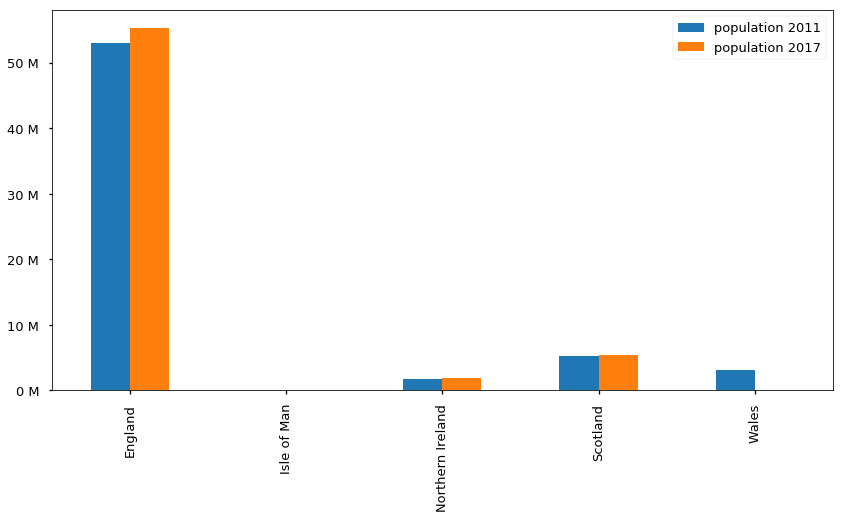

In [43]:
plot = data[['population 2011', 'population 2017']].plot(kind='bar', figsize=(14, 7))
ticks = ['%.0f M' % (x[1] / 1e6) for x in plot.yaxis.iter_ticks()]
plot.yaxis.set_ticklabels(ticks);  # this is just a hack to get nice ticks

And, on a logarithmic scale, we can see the relation between area and population.

Here we also use annotations, this is a `matplotlib` feature.
It annotates the string (first argument) over a point on the graph
(two coordinates - as a tuple, list or series).

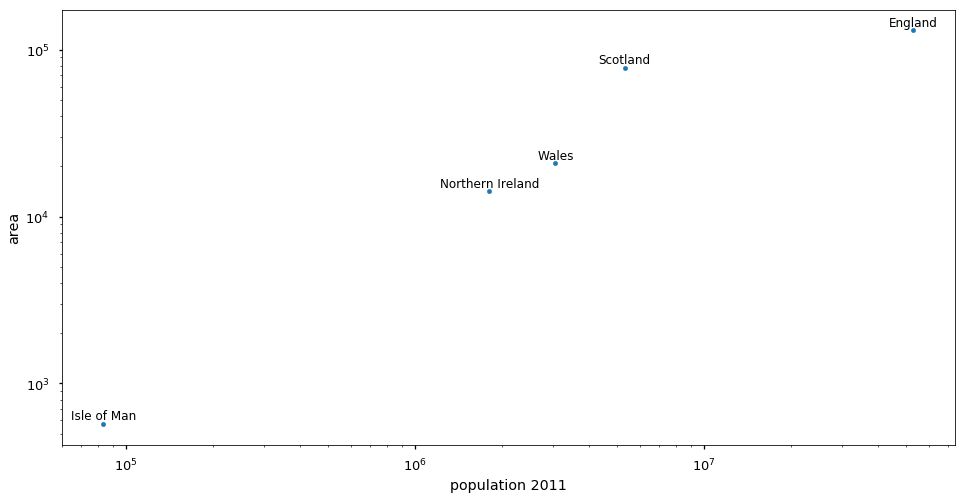

In [44]:
plot = data.plot(kind='scatter', x='population 2011', y='area', loglog=True, figsize=(16, 8))
for k, v in data[['population 2011', 'area']].iterrows():
    plot.axes.annotate(k, xy=v, xytext=(v[0], v[1]*1.07), ha='center', size=12)

### String methods

Another extra feature that does not exist in `NumPy` arrays are methods that work
on string content, just like Python string methods.  The `str` object of a `Series`
(of a column of a data frame) is used to call string methods on each element, efficiently.
The result is either a boolean `Series` that can then be used to retrieve rows from the data frame,
or a new string `Series` modified by the operation.

In [45]:
data['capital'].str.startswith('Be')

England             False
Isle of Man         False
Northern Ireland     True
Scotland            False
Wales               False
Name: capital, dtype: bool

Several regular expression methods are supported as well.

In [46]:
data[data.capital.str.contains('[oa]')]

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0
Isle of Man,572,Douglas,83314,NaN
Northern Ireland,14130,Belfast,1810863,1876695.0
Wales,20779,Cardiff,3063456,NaN


In [47]:
data[data.index.str.startswith('Eng')]

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0


Most string Python methods are available.

In [48]:
data['capital'].str.upper()

England                LONDON
Isle of Man           DOUGLAS
Northern Ireland      BELFAST
Scotland            EDINBURGH
Wales                 CARDIFF
Name: capital, dtype: object

To modify the data frame we can assign to a new column.
For example, first letter of the capital.

In [49]:
data['initial'] = data['capital'].str[0].str.upper()
data

,area,capital,population 2011,population 2017,initial
England,130279,London,53012456,55268100.0,L
Isle of Man,572,Douglas,83314,NaN,D
Northern Ireland,14130,Belfast,1810863,1876695.0,B
Scotland,77933,Edinburgh,5313600,5404700.0,E
Wales,20779,Cardiff,3063456,NaN,C


Note above that `.str` has been used two times.

### Missing data

More often than not real world data is incomplete in some way.
In `NumPy`, and therefore in `pandas`, missing data is represented using NaNs (not a number).
NaNs are actuall IEEE 754 float NaNs, therefore the data type of a `Series` (or `NumPy` array)
must be either a float or a Python object.  `Series` strings are just Python objects,
this is contrary to `NumPy`'s arrays; this means that a `series` or a data frame can hold
NULLs (NaNs) for strings.

`pandas` data frames have the `dropna` an `fillna` methods that
(unsurprisingly) drop or fill in values for NaNs.
Dropping can be done by row or column.

In [50]:
data = pd.DataFrame({'capital': capital,
                     'area': area,
                     'population 2011': population2011,
                     'population 2017': population2017},
                    index=country).sort_index()

In [51]:
data.dropna()

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100.0
Northern Ireland,14130,Belfast,1810863,1876695.0
Scotland,77933,Edinburgh,5313600,5404700.0


We lost the data for the Isle of Man, despite the fact that it has data for 2011.
Instead we can drop the incomplete columns.

In [52]:
data.dropna(axis='columns')

,area,capital,population 2011
England,130279,London,53012456
Isle of Man,572,Douglas,83314
Northern Ireland,14130,Belfast,1810863
Scotland,77933,Edinburgh,5313600
Wales,20779,Cardiff,3063456


That's better.

Instead of `NumPy`s `axis=0` and `axis=1`,
in `pandas` one can use `axis='index'` and `axis='columns'`.
That is, most of the time,
some `pandas` functions do accept `axis='row'` and `axis='col'`, beware.

Filling NaNs can be performed in three different ways:
we can provide a value into `fillna` to substitute the NaNs for (e.g. `.fillna(0)`); or we can use
the `method=` argument to use a predefined way of filling the NaNs from the data itself.  The `method=`
can be either `pad`/`ffill` which will fill each NaN with a previous (non-NaN) value seen; or it can be
`backfill`/`bfill` which will fill a NaN from the next value.
Filling can be performed column or row wise.

In [53]:
data_full = data.fillna(method='ffill', axis='columns')
data_full

,area,capital,population 2011,population 2017
England,130279,London,53012456,5.52681e+07
Isle of Man,572,Douglas,83314,83314
Northern Ireland,14130,Belfast,1810863,1.8767e+06
Scotland,77933,Edinburgh,5313600,5.4047e+06
Wales,20779,Cardiff,3063456,3063456


That seems to have worked but not quite.
The numbers look wrong.  We better check the data types.

In [54]:
data_full.dtypes

area               object
capital            object
population 2011    object
population 2017    object
dtype: object

Everything got converted to Python objects!
That is the caveat of filling NaNs between columns, i.e. we lose data types.
We can fix this with some data munging.
We will separate the columns that need filling from the rest,
perform the filling, fix the data types on the reduced data frame and join things back.

In [55]:
data_partial = data[['population 2011', 'population 2017']].fillna(method='ffill', axis='columns')
# the following is slightly overkill for numbers but useful if we have more columns
data_partial = data_partial.apply(pd.to_numeric, errors='ignore')
data_partial = data_partial.astype(np.integer, errors='ignore')
data_full = pd.concat([data[['area', 'capital']], data_partial], axis='columns')
data_full.dtypes

area                int64
capital            object
population 2011     int64
population 2017     int64
dtype: object

That appears to be right.
But we used a new concept here: we split and joined back two data frames.
`pandas` has `.concat`, which allow for joins on `axis`,
it accepts a `join` parameter for "inner" or "outer" joins.
The join will happen on the index by default.

`pandas` function `merge` has left and right joins using columns as join keys.
And finally the data frame itself has a `join` method which can use either
`concat` or `merge` directly on the data frames.
All three methods are more-or-less interchangeable,
their difference is mostly how parameters are passed in.

But still, let's look whether the data in the joined frame is as correct
as the data types suggest.

In [56]:
data_full

,area,capital,population 2011,population 2017
England,130279,London,53012456,55268100
Isle of Man,572,Douglas,83314,83314
Northern Ireland,14130,Belfast,1810863,1876695
Scotland,77933,Edinburgh,5313600,5404700
Wales,20779,Cardiff,3063456,3063456
